In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Processing with Neural Network
## Session 17b : Convolutional Neural Network (CNN) U-Net
<img src='../../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com"/>

<img src='../../../images/unet_architecture.png' style = 'width:1200px;' alt="U-Net" align="left"/>

The architecture has a "U" shape. The architecture is symmetric and consists of two major parts — the left part is called contracting path, which is constituted by the general convolutional process; the right part is expansive path, which is constituted by transposed 2d convolutional layers.

In [2]:
### Import Libraries

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary

from tqdm import tqdm

from utils.helper import fn_plot_confusion_matrix, fn_plot_torch_hist

In [3]:
# Some basic parameters

inpDir = '../../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'cityscapes_data' # location of the images
modelDir = '../models'
altName = 'unet_city'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

EPOCHS = 10 # number of cycles to run

BATCH_SIZE = 4

ALPHA = 0.01
IMG_SIZE = 128
IMG_SIZE_ORIG = 101


ES_PATIENCE = 10 # if performance does not improve stop
LR_PATIENCE = 5 # if performance is not improving reduce alpha
LR_FACTOR = 0.1 # rate of reduction of alpha


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,4),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


## Load Dataset

In [5]:
# Directory where images are stored
data_dir = os.path.join(inpDir, subDir)

# train subdirectory
train_dir = os.path.join(data_dir, "train") 

# validation sub directory
val_dir = os.path.join(data_dir, "val")

# list of training images
train_fns = os.listdir(train_dir)

# list of validation images
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

2975 500


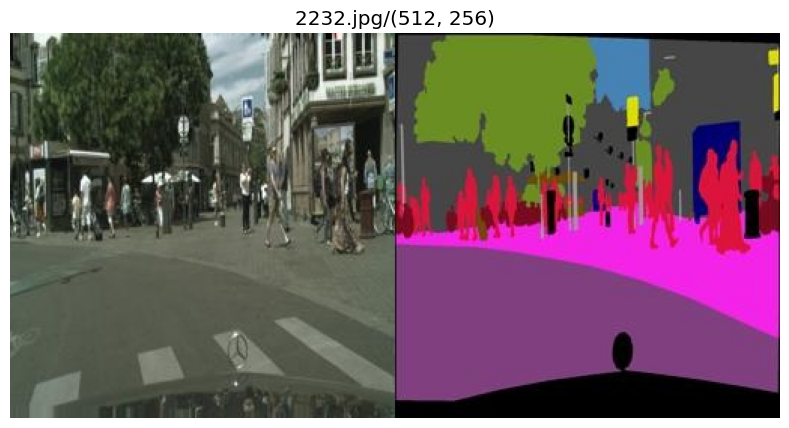

In [6]:
# pick one sample
sample_image_fp = os.path.join(train_dir, train_fns[0])

# read file using PIL Image
sample_image = Image.open(sample_image_fp).convert("RGB")

# instantiate a figure
fig = plt.figure(figsize = (15,5))

# add a subplot
ax = fig.add_subplot(111)

# trunoff the grid
ax.grid(False)

# display image
ax.imshow(sample_image)

# add file name to title
ax.set_title(f'{train_fns[0]}/{sample_image.size}')

# no axis
ax.axis("off");

### Note:
images are of size 256 x 512
- first 256 x 256 are images
- rest is mask

Following function is to split image into cityscapes and labels

In [7]:
def split_image(image):
    # convert to numpy array
    image = np.array(image)
    # split by index
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    # Return arrays
    return cityscape, label

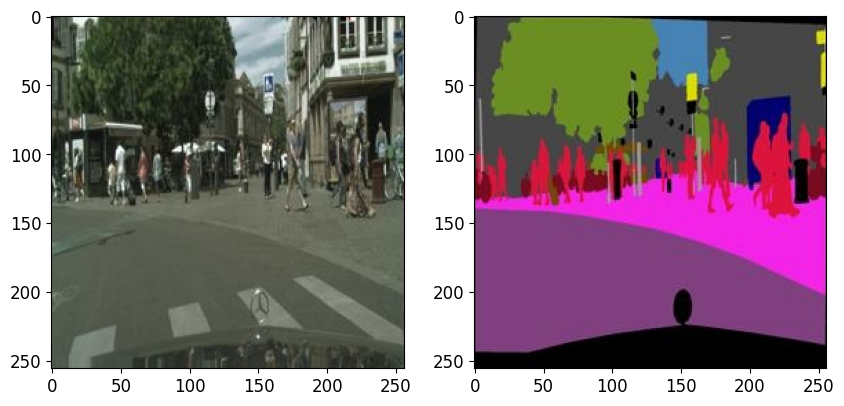

In [8]:
# Convert to numpy array
sample_image = np.array(sample_image)
#print(sample_image.shape)

# split the image in two
cityscape, label = split_image(sample_image)
#print(cityscape.min(), cityscape.max(), label.min(), label.max())

# 
#cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)

# Instantiate fig and axis
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# display cityscape
axes[0].imshow(cityscape)

# display label
axes[1].imshow(label);

## Define Labels

In [9]:
"""
color_set = set()
for train_fn in tqdm(train_fns[:10]):
    train_fp = os.path.join(train_dir, train_fn)
    image = np.array(Image.open(train_fp))
    cityscape, label = split_image(sample_image)
    label = label.reshape(-1, 3)
    local_color_set = set([tuple(c) for c in list(label)])
    color_set.update(local_color_set)
color_array = np.array(list(color_set))
"""
## Alternatively we can pick a random combination to make it faster
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[119 217 115]
 [125 235  47]
 [ 43 241 155]
 [238  95 142]
 [103 133 196]]


In [10]:
num_classes = 10
label_model = KMeans(n_clusters=num_classes, n_init = 'auto')
label_model.fit(color_array)

KMeans(n_clusters=10)

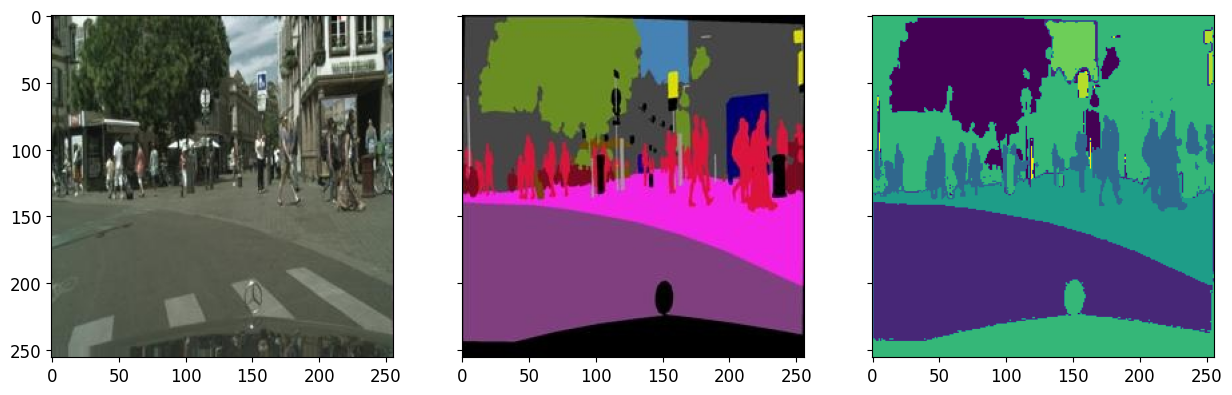

In [11]:
# split a sample image
cityscape, label = split_image(sample_image)

# make prediction using KMeans
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)

# display all three
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey = True)
axes[0].imshow(cityscape) # city scape
axes[1].imshow(label) # Original label
axes[2].imshow(label_class); # predicted label

## Define DataSet

Defining a class to prepare dataset

In [12]:
class CityscapeDataset(Dataset):
    # extending from Dataset
    
    def __init__(self, image_dir, label_model):
        '''
        Args:
            image_dir: directory where all the images are stored
            label_model : model used to create labels
        '''
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns) # size of the dataset
    
    def __getitem__(self, index): # get items as per index
        '''
        Args:
            index: list of index to return the images
        '''
         # image file names
        image_fn = self.image_fns[index]
        # image file paths
        image_fp = os.path.join(self.image_dir, image_fn) 
        # load image from the image path
        image = Image.open(image_fp).convert('RGB')
        # convert to numpy array
        image = np.array(image)
        # split the images in image and label
        cityscape, label = self.split_image(image)
        # make a prediction of individual pixel
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        # use transform to make it compatible with pytorch model
        cityscape = self.transform(cityscape)
        #convert class to tensor
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        '''
        Args:
            image: image to split
        '''
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label
    
    def transform(self, image):
        '''
        Args:
            pytorch transform normalizes the images and moves them to tensor
        '''
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [13]:
# convert to training dataset
dataset = CityscapeDataset(train_dir, label_model)

print(len(dataset))

2975


In [14]:
cityscape, label_class = dataset[0]
print(cityscape.shape, label_class.shape)

torch.Size([3, 256, 256]) torch.Size([256, 256])


## Define Model

In [15]:
class UNet(nn.Module):
    # extend from nn.Module
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        
        self.num_classes = num_classes # how many classes
        ###------------
        ### Down sizing
        ###------------
        # Set 1
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Set 2
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Set 3
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        # set 4
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        ###-------
        ### Middle
        ###-------
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        ###----------
        ### up sizing
        ###----------
        # Set 1
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        # set 2
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        # set 3
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        # set 4
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        ###----------
        ### output
        ###----------        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        '''
        Args:
            in_channels : incomming channels
            out_channels : outgoing channels
        '''
        # each block contains 
        # Conv2d => ReLU 
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True))
        
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [16]:
model = UNet(num_classes=num_classes)

In [17]:
print (model)

UNet(
  (contracting_11): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (contracting_12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contracting_21): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (cont

In [18]:
data_loader = DataLoader(dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [19]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


## Train the model

In [20]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [21]:
model_path = os.path.join(modelDir, subDir, 'u_net.pth')

model = UNet(num_classes=num_classes).to(device)
if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path))
    ALPHA = 0.001
    print (f'Loading model from {model_path}')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=ALPHA)

In [23]:
step_losses = []
epoch_losses = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for X, Y in data_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))

/home/pks/May2024/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/pks/May2024/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


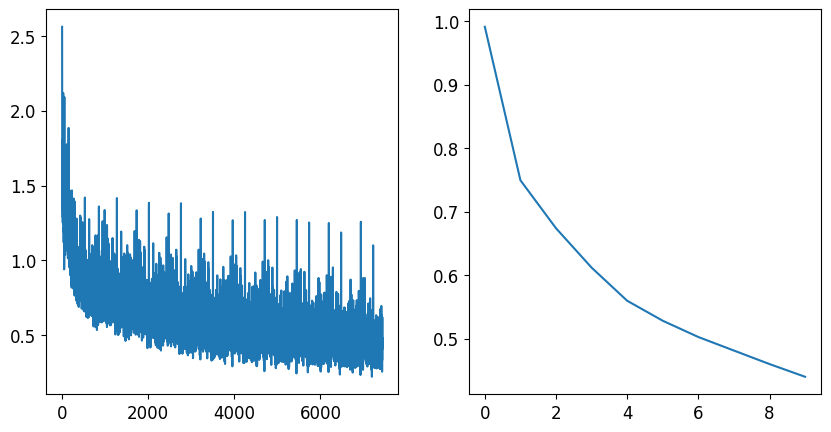

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

In [26]:
torch.save(model.state_dict(), model_path)

## Predict

In [27]:
model1 = UNet(num_classes=num_classes).to(device)
model1.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [28]:
test_batch_size = 4
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

In [29]:
X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model1(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])
torch.Size([4, 256, 256])


In [30]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

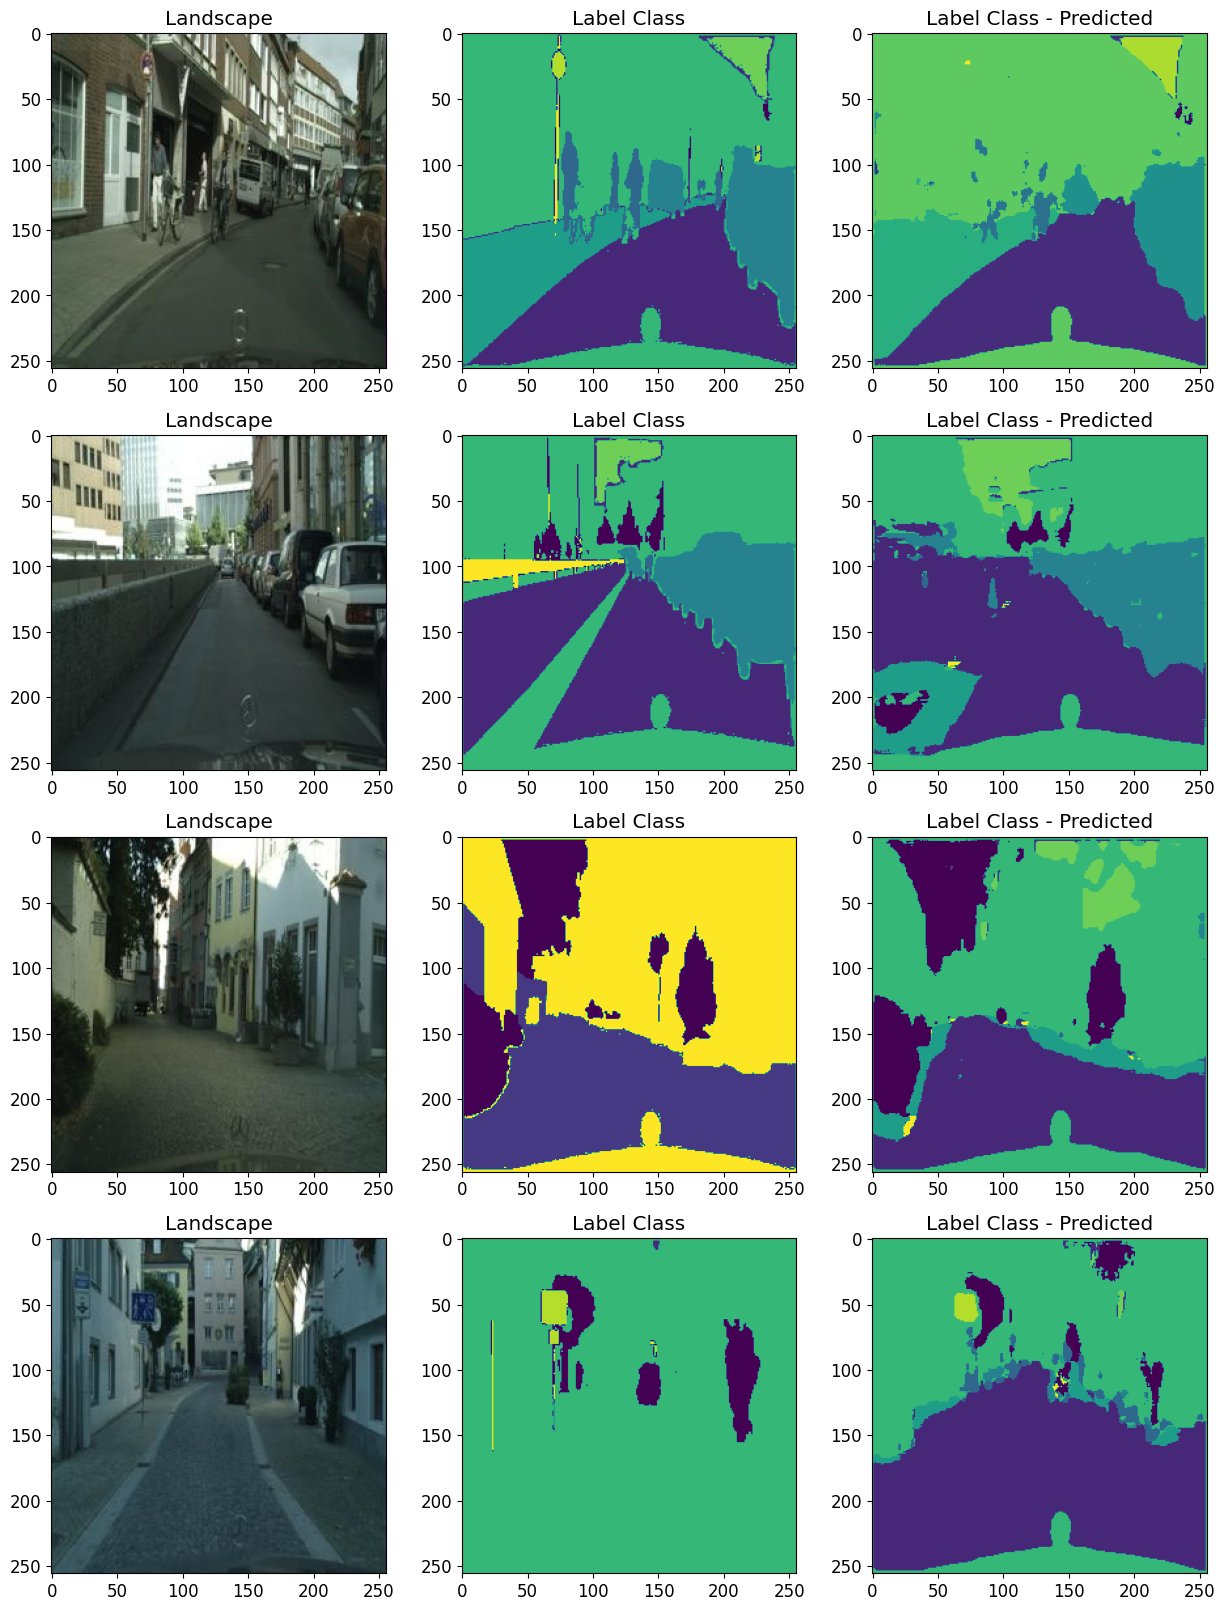

In [31]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [ ]:
del model1